In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import numpy as np

from data import BraTSDataset

from IPython.display import HTML

In [2]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Dataset configuration
dataset_root = "dataset"
t1_train_data = "data/MICCAI_BraTS2020/train/t1"

# Critic model configuration
use_gp = True
lambda_gp = 10
# clipping param won't be used if use_gp is True
clipping_param = 0.01

# Generator model configuration
latent_size = 200

# Training configuration
device = torch.device("cuda:0")
batch_size = 16
real_label = -1.0
fake_label = 1.0
n_epochs = 50
n_critic = 5

# Dataset configuration
image_size = 240
num_workers = 16

In [4]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = BraTSDataset(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [5]:
real_batch = next(iter(dataloader))

torch.Size([16, 1, 240, 240])


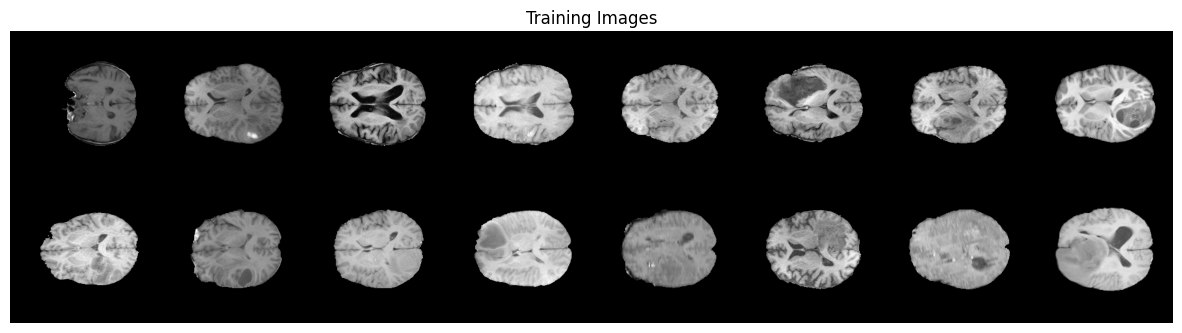

In [6]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [7]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [8]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x 240 x 240
                nn.Conv2d(1, 128, 4, stride=2, padding=9),
                nn.LeakyReLU(0.2),
                # input: 128 x 128 x 128
                nn.Conv2d(128, 64, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 64 x 64 x 64
                nn.Conv2d(64, 32, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 32 x 32 x 32
                nn.Conv2d(32, 16, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 16 x 16 x 16
                nn.Conv2d(16, 8, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 8 x 8 x 8
                nn.Conv2d(8, 4, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 4 x 4 x 4
                nn.Conv2d(4, 1, 4, stride=1, padding=0),
                # input: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x 240 x 240
                nn.Conv2d(1, 128, 4, stride=2, padding=9),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2),
                # input: 128 x 128 x 128
                nn.Conv2d(128, 64, 4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2),
                # input: 64 x 64 x 64
                nn.Conv2d(64, 32, 4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2),
                # input: 32 x 32 x 32
                nn.Conv2d(32, 16, 4, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.2),
                # input: 16 x 16 x 16
                nn.Conv2d(16, 8, 4, stride=2, padding=1),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(0.2),
                # input: 8 x 8 x 8
                nn.Conv2d(8, 4, 4, stride=2, padding=1),
                nn.BatchNorm2d(4),
                nn.LeakyReLU(0.2),
                # input: 4 x 4 x 4
                nn.Conv2d(4, 1, 4, stride=1, padding=0),
                # input: 1 x 1 x 1
            )
    
    def forward(self, input):
        return self.main(input)

In [9]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(9, 9))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(4, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [10]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 128, 4, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # input: 128 x 4 x 4
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # input: 64 x 8 x 8
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            # input: 32 x 16 x 16
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # input: 16 x 32 x 32
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            # input: 8 x 64 x 64
            nn.ConvTranspose2d(8, 4, 4, 2, 1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2),
            # input: 4 x 128 x 128
            nn.ConvTranspose2d(4, 1, 4, 2, 9),
            nn.Tanh()
            # output: 1 x 240 x 240
        )
    
    def forward(self, input):
        return self.main(input)

In [11]:
generator_model = Generator().to(device)
generator_model.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=

In [12]:
optimizer_critic = optim.RMSprop(critic_model.parameters(), lr=5e-5)
optimizer_generator = optim.RMSprop(generator_model.parameters(), lr=5e-5)

In [13]:
# Training loop
print("Starting training....")
fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)
img_list = list()
d_loss_hist = list()
g_loss_hist = list()
best_g_loss = float("inf")
best_g_weights = None
best_d_weights = None

print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data.to(device)
        b_size = real_batch.shape[0]

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)

        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

        # Summarize performance
        if i % 12 == 0:
            tqdm.write(f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f}")
        
        # Save best model
        if g_loss_hist[-1] < best_g_loss:
            best_g_weights = generator_model.state_dict()
            best_d_weights = critic_model.state_dict()
            best_g_loss = g_loss_hist[-1]

        # Check how the generator is doing by saving G's output on fixed_noise
        if (i % 12 == 0 or ((epoch == n_epochs - 1) and (i == len(dataloader) - 1))):
            with torch.no_grad():
                fake = generator_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting training....
Number of mini batch iterations per epoch: 24


0it [00:00, ?it/s]MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_14.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
1it [00:29, 29.98s/it]

epoch: 0, d_loss: 9.9999, g_loss: 0.0085


13it [00:46,  1.50s/it]

epoch: 0, d_loss: -22.3399, g_loss: 50.3540


24it [01:18,  3.25s/it]
1it [00:05,  5.04s/it]

epoch: 1, d_loss: -722.2076, g_loss: 1100.4061


13it [00:21,  1.40s/it]

epoch: 1, d_loss: -2250.8345, g_loss: 4675.3423


24it [00:35,  1.47s/it]
1it [00:05,  5.00s/it]

epoch: 2, d_loss: -4474.8193, g_loss: 10968.8887


5it [00:10,  1.68s/it]

In [ ]:
# Plot training history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_loss_hist, label='d_loss')
plt.plot(g_loss_hist, label='g_loss')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[-50:]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Save models weights
# model dir should be models/wgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

In [ ]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"

# Load model and perform inference
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)
print(critic_model)

generator_model = Generator().to(device)
generator_model.apply(weight_init)
print(generator_model)

critic_model.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
generator_model.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

generator_model.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = generator_model(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")